# Imports

In [1]:
from dqn.dqn import QNetwork, ReplayMemory
from policies.eps_greedy import EpsilonGreedyPolicy
from train_eval.train import train as train_baseline
from train_eval.train_target import train as train_target

import random
import numpy as np
import torch
from torch import optim
import gym
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy

# Load the environment

In [2]:
env = gym.envs.make("CartPole-v1")

C:\Users\kylia\Anaconda3\envs\rl2020\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


# Function to run episodes and call training function (baseline)

In [3]:
def run_episodes(train, Q, policy, memory, env, num_episodes, batch_size, discount_factor, optimizer):
    global_steps = 0  # Count the steps (do not reset at episode start, to compute epsilon)
    episode_durations = []  #
    state_values = []
    init_state = env.reset()
    for i in tqdm(range(num_episodes)):
        state = env.reset()

        steps = 0
        while True:
            # Set epsilon according to number of steps
            policy.set_epsilon(global_steps)
            # Increase step counts
            steps += 1
            global_steps += 1
            # Sample an action, next state, reward and done
            a = policy.sample_action(state)
            s_next, r, done, _ = env.step(a)
            # Add the transition to the memory buffer
            memory.push((state, a, r, s_next, done))
            # Perform training on the buffer
            if global_steps % batch_size == 0:
                loss = train(Q, memory, optimizer, batch_size, discount_factor)
            state = s_next
            
            if i % 100 == 0:
                with torch.no_grad():
                    Q.eval()
                    Q_vals = Q(torch.Tensor([init_state]))
                    maxx, _ = torch.max(Q_vals, dim=1)
                    state_values.append(maxx)

            if done:
#                 if i % 100 == 0:
#                     print("{2} Episode {0} finished after {1} steps"
#                           .format(i, steps, '\033[92m' if steps >= 195 else '\033[99m'))
                episode_durations.append(steps)
                break
    return episode_durations, state_values

# Train network

In [4]:
seed = 42  # This is not randomly chosen
num_hidden = 128
eps = 0.05

# We will seed the algorithm (before initializing QNetwork!) for reproducibility
random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

Q_net = QNetwork(num_hidden=num_hidden)
policy = EpsilonGreedyPolicy(Q_net, eps)

num_episodes = 10000
batch_size = 64
discount_factor = 0.9
learn_rate = 1e-3
memory = ReplayMemory(batch_size)

optimizer = optim.Adam(Q_net.parameters(), learn_rate)
episode_durations, state_values = run_episodes(train_baseline, Q_net, policy, memory, env, num_episodes, batch_size, discount_factor, optimizer)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 888.61it/s]


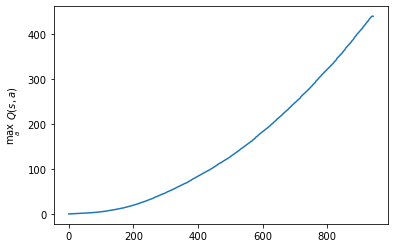

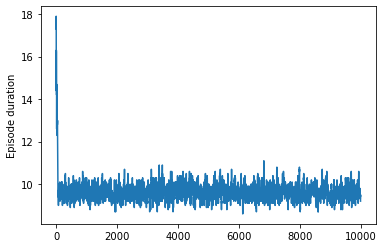

In [5]:
def smooth(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

plt.plot(smooth(np.array(state_values), 10))
plt.ylabel('$\max_a\ Q(s,a)$')
plt.show()

plt.plot(smooth(np.array(episode_durations), 10))
plt.ylabel('Episode duration')
plt.show()

# Using a target network

In [6]:
def run_episodes_target(train, Q, policy, memory, env, num_episodes, batch_size, discount_factor, optimizer, update_freq):
    global_steps = 0  # Count the steps (do not reset at episode start, to compute epsilon)
    episode_durations = []  #
    state_values = []
    init_state = env.reset()
    Q_target = deepcopy(Q)
    for i in range(num_episodes):
        state = env.reset()

        steps = 0
        while True:
            # Set epsilon according to number of steps
            policy.set_epsilon(global_steps)
            # Increase step counts
            steps += 1
            global_steps += 1
            # Sample an action, next state, reward and done
            a = policy.sample_action(state)
            s_next, r, done, _ = env.step(a)
            # Add the transition to the memory buffer
            memory.push((state, a, r, s_next, done))
            # Update target network parameters if required
            if (global_steps // batch_size) % update_freq == 0:
                Q_target = deepcopy(Q)
            # Perform training on the buffer
            if global_steps % batch_size == 0:
                loss = train(Q, Q_target, memory, optimizer, batch_size, discount_factor)
            state = s_next
            
            if done:
#                 if i % 100 == 0:
#                     print("{2} Episode {0} finished after {1} steps"
#                           .format(i, steps, '\033[92m' if steps >= 195 else '\033[99m'))
                episode_durations.append(steps)
                break
        if i % 10 == 0:
            with torch.no_grad():
                Q.eval()
                Q_vals = Q(torch.Tensor([init_state]))
                maxx, _ = torch.max(Q_vals, dim=1)
                state_values.append(maxx)
    return episode_durations, state_values

In [7]:
seed = 42  # This is not randomly chosen
num_hidden = 128
eps = 0.05

# We will seed the algorithm (before initializing QNetwork!) for reproducibility
random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

Q_net = QNetwork(num_hidden=num_hidden)
policy = EpsilonGreedyPolicy(Q_net, eps)

num_episodes = 8000
batch_size = 64
discount_factor = 0.9
learn_rate = 1e-3
memory = ReplayMemory(batch_size)

# We test this parameter. If target_update_freq == 10 then the target network is updated every 10 batches.
target_update_freq = 10

optimizer = optim.Adam(Q_net.parameters(), learn_rate)
episode_durations, state_values = run_episodes_target(
        train_target,
        Q_net, policy,
        memory,
        env,
        num_episodes,
        batch_size,
        discount_factor,
        optimizer,
        target_update_freq
)

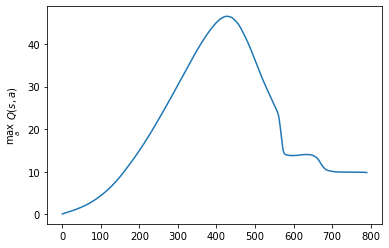

800 8000


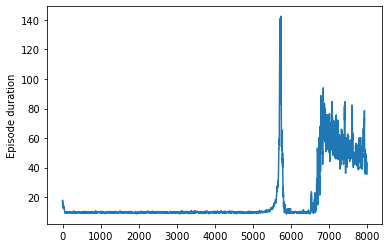

In [8]:
plt.plot(smooth(np.array(state_values), 10))
plt.ylabel('$\max_a\ Q(s,a)$')
plt.show()
print(len(state_values), len(episode_durations))
plt.plot(smooth(np.array(episode_durations), 10))
plt.ylabel('Episode duration')
plt.show()

# Proof of concept done, time for testing

In [9]:
# Fixed hyperparams among experiments
num_hidden = 128
eps = 0.05
num_episodes = 10000
batch_size = 64
discount_factor = 0.9
learn_rate = 1e-3

# Number of experiments to average results over
num_experiments = 10

# Update frequencies to be tested
test_freqs = [1, 5, 10, 20]

# Make buffers for the cumulative results
cum_state_values = {i : [] for i in test_freqs}
cum_episode_durations = {i : [] for i in test_freqs}

for update_freq in test_freqs:
    for i in tqdm(range(num_experiments)):
        
        # Set the seed such that each update frequency is tested on the same seeds
        random.seed(i)
        torch.manual_seed(i)
        env.seed(i)
        
        # Create network, policy and replaymemory (which is not used; renewed every batch)
        Q_net = QNetwork(num_hidden=num_hidden)
        policy = EpsilonGreedyPolicy(Q_net, eps)
        memory = ReplayMemory(batch_size)

        optimizer = optim.Adam(Q_net.parameters(), learn_rate)
        episode_durations, state_values = run_episodes_target(
                train_target,
                Q_net, policy,
                memory,
                env,
                num_episodes,
                batch_size,
                discount_factor,
                optimizer,
                update_freq
        )
        cum_state_values[update_freq].append(np.array(state_values))
        cum_episode_durations[update_freq].append(np.array(episode_durations))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [07:00<00:00, 48.57s/it]


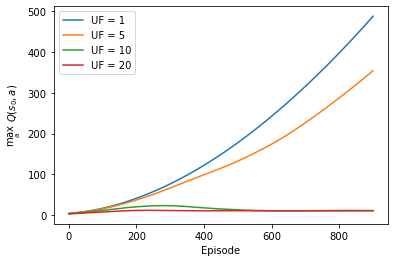

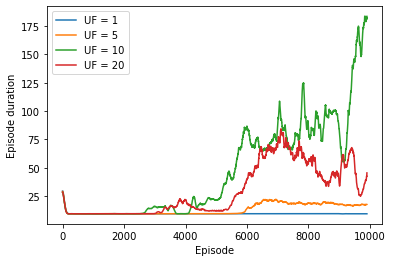

In [13]:
# Average over the cumulative results
for freq in test_freqs:
    cum_state_values[freq] = np.array(cum_state_values[freq])
    cum_episode_durations[freq]  = np.array(cum_episode_durations[freq])

for freq in test_freqs:
    plt.plot(smooth(np.mean(cum_state_values[freq], axis=0), 100))
plt.ylabel('$\max_a\ Q(s_0,a)$')
plt.xlabel('Episode')
plt.legend([f'UF = {freq}' for freq in test_freqs])
plt.show()

for freq in test_freqs:
    plt.plot(smooth(np.mean(cum_episode_durations[freq], axis=0), 100))
plt.ylabel('Episode duration')
plt.xlabel('Episode')
plt.legend([f'UF = {freq}' for freq in test_freqs])
plt.show()